# 机器学习练习1 - 线性回归

## 线性回归

用函数一个个讲解

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams  ## run command settings for plotting
from sklearn.model_selection import RepeatedKFold

In [3]:
config = {
    "mathtext.fontset":'stix',
    "font.family":'serif',
    "font.serif": ['SimHei'],
    "font.size": 10,   # 字号，大家自行调节
    'axes.unicode_minus': False # 处理负号，即-号
}
rcParams.update(config)  ## 设置画图的一些参数

In [4]:
## 读取数据
path = 'D:\作业\机器学习\Homework_demo/regress_data1.csv'
import pandas as pd
data = pd.read_csv(path) ## data 是dataframe 的数据类型
data.head() # 返回data中的前几行数据，默认是前5行。  


,人口,收益
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


In [5]:
cols = data.shape[1]
X_data = data.iloc[:,:cols-1]#X是所有行，去掉最后一列， 未标准化
y_data = data.iloc[:,cols-1:]#X是所有行，最后一列

In [6]:
data.describe() ## 查看数据的统计信息

,人口,收益
count,97.000000,97.000000
mean,8.159800,5.839135
std,3.869884,5.510262
min,5.026900,-2.680700
25%,5.707700,1.986900
50%,6.589400,4.562300
75%,8.578100,7.046700
max,22.203000,24.147000


看下数据长什么样子，进行画图

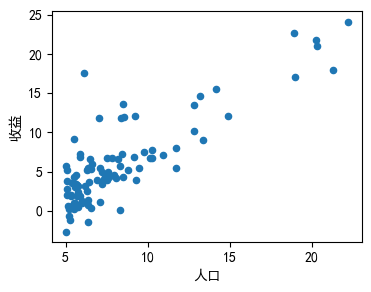

In [8]:
data.plot(kind='scatter', x='人口', y='收益', figsize=(4,3)) # 利用散点图可视化数据
import matplotlib
plt.xlabel('人口')
plt.ylabel('收益', rotation=90)
plt.show()

使用重复K折交叉验证数据划分法获得训练集和测试

In [ ]:
kf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=None)
for train_index, test_index in kf.split(X_data):
    x_train, x_test = X_data.iloc[train_index], X_data.iloc[test_index]
    y_train, y_test = y_data.iloc[train_index], y_data.iloc[test_index]

x_train.insert(0, 'Ones', 1)
X_train = x_train.values
Y_train = y_train.values.reshape(-1, 1)

让我们在训练集中添加一列，以便我们可以使用向量化的解决方案来计算代价和梯度。

In [9]:
X_data.insert(0, 'Ones', 1)


从数据中分离出特征属性X和目标向量Y，并对模型参数进行初始化，同时计算当前的损失。

观察下 X (训练集) and y (目标变量)是否正确.

In [10]:
X_data.head()#head()是观察前5行

,Ones,人口
0,1,6.1101
1,1,5.5277
2,1,8.5186
3,1,7.0032
4,1,5.8598


In [11]:
y_data.head()

,收益
0,17.5920
1,9.1302
2,13.6620
3,11.8540
4,6.8233


代价函数是应该是numpy数组，所以我们需要从dataframeX_data和Y_data中读取数据，然后才能使用它们。
此外，我们还需要初始化w。

In [12]:
X=X_data.values
Y=y_data.values
W=np.array([[0.0],[0.0]]) ## 初始化W系数矩阵，w 是一个(2,1)矩阵

看下维度

In [13]:
(X.shape,Y.shape, W.shape)

((97, 2), (97, 1), (2, 1))

对于线性回归问题，假设模型的输出服从高斯分布（正态分布），即：

$$
y^{(i)} \sim \mathcal{N}(h_w(x^{(i)}), \sigma^2)
$$

其中，$$ h_w(x^{(i)}) $$是模型预测的输出，$$ \sigma^2 $$ 是高斯分布的方差。

定义高斯分布的概率密度函数为：

$$
P(y^{(i)} | x^{(i)}, w) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(y^{(i)} - h_w(x^{(i)}))^2}{2\sigma^2}\right)
$$

根据极大似然估计的原理，需要最大化观测到的数据的联合概率密度。假设有 $m$个训练样本，观测到的数据为 $$ (x^{(1)}, y^{(1)}), (x^{(2)}, y^{(2)}), ..., (x^{(m)}, y^{(m)}) $$。因为每个样本的观测是独立同分布的，所以联合概率密度为各个样本概率密度的乘积：

$$
L(w) = \prod_{i=1}^{m} P(y^{(i)} | x^{(i)}, w)
$$

为了方便计算，对上述联合概率密度取对数，将乘积转化为求和：

$$
\ell(w) = \log L(w) = \sum_{i=1}^{m} \log P(y^{(i)} | x^{(i)}, w)
$$

最大化 $ \ell(w) $，等价于最小化 $ -\ell(w) $。推导出损失函数，进而可求解最优的参数 $ w $。

首先，考虑到高斯分布的概率密度函数，有：

$$
\log P(y^{(i)} | x^{(i)}, w) = \log\left(\frac{1}{\sqrt{2\pi\sigma^2}}\right) - \frac{(y^{(i)} - h_w(x^{(i)}))^2}{2\sigma^2}
$$

其中，$$\log\left(\frac{1}{\sqrt{2\pi\sigma^2}}\right) $$是一个与 $ w $ 无关的常数，因此在最大化似然估计时可以忽略。

展开 $ \ell(w) $：

$$
\ell(w) = \sum_{i=1}^{m} \left( -\frac{(y^{(i)} - h_w(x^{(i)}))^2}{2\sigma^2} \right)
$$

然后将 $ h_w(x^{(i)}) $展开为模型的假设函数 $ h_w(x) $：

$$
\ell(w) = \sum_{i=1}^{m} \left( -\frac{(y^{(i)} - (w_0 + w_1 x_1^{(i)} + w_2 x_2^{(i)} + ... + w_n x_n^{(i)}))^2}{2\sigma^2} \right)
$$

将 $ \ell(w) $ 改写成损失函数的形式。在这里，使用l2正则化项。得到最小化如下形式的损失函数：

$$
J(w) = \frac{1}{2m} \sum_{i=1}^{m} (h_{w}(x^{(i)}) - y^{(i)})^2 + \frac{\lambda}{2m} \sum_{j=1}^{n} w_j^2
$$

这里的第一项是平方误差项，第二项是 L2 正则化项。
其中：
- $\lambda$ 是正则化参数。
- $m$ 是样本数量。
- $n$ 是特征的数量。
- $w_j$ 是模型的参数，表示第 $j$ 个特征的权重。

重定义损失函数

In [14]:
def computeCost2(X, Y, W, lambda_val):
    m = len(Y)
    predicted = np.dot(X, W)
    error = predicted - Y
    squared_error = np.sum(np.square(error)) / (2 * m) #均方误差
    reg_term = (lambda_val / (2 * m)) * np.sum(np.square(W)) #偏置值
    loss = squared_error + reg_term
    return loss

In [15]:
def gradientDescent2(X, Y, W, alpha, lambda_val):
    m = len(Y)
    predicted = np.dot(X, W)
    error = predicted - Y
    dW = np.dot(X.T, error) / m + (lambda_val / m) * W #权重系数求导
    W -= alpha * dW
    return W

岭回归模型下的预测(未归一化)

In [16]:
def linear_Ridge(X, Y, alpha, iters, lambda_val):
    loss_his = []
    feature_dim = X.shape[1]
    W = np.zeros((feature_dim, 1))  # 初始化权重系数矩阵
    for i in range(iters):
        loss = computeCost2(X, Y, W, lambda_val)
        loss_his.append(loss)
        W = gradientDescent2(X, Y, W, alpha, lambda_val)
    
    return loss_his, W 


In [17]:
def predict(X, W):
    '''
    输入：
        X：测试数据集
        W：模型训练好的参数
    输出：
        y_pre：预测值
    '''
    y_pre = np.dot(X,W)
    return y_pre



In [18]:
alpha =0.0001
iters = 10000
lambda_val=0.5
loss_his2,W2=linear_Ridge(X,Y,alpha,iters,lambda_val)

In [19]:
W2

array([[-0.57439024],
       [ 0.85931367]])

现在我们来绘制线性模型以及数据，直观地看出它的拟合。
这是引入l2正则项后的拟合曲线

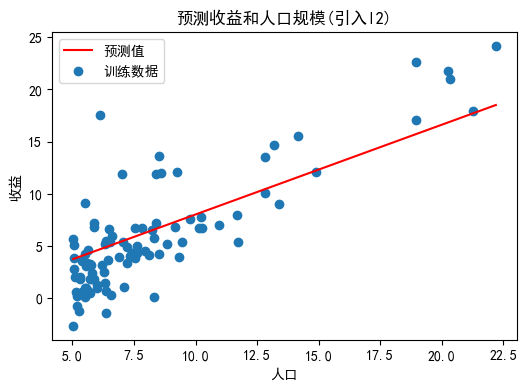

In [20]:
x = np.linspace(X_data['人口'].min(), X_data['人口'].max(), 100)
f = W2[0, 0] + (W2[1, 0] * x)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, f, 'r', label='预测值')
ax.scatter(X_data['人口'], data['收益'], label='训练数据')
ax.legend(loc=2)
ax.set(xlabel='人口',
       ylabel='收益',
       title='预测收益和人口规模(引入l2)')
plt.show()

由于梯度方程式函数也在每个训练迭代中输出一个代价的向量，所以我们也可以绘制。 请注意，代价总是降低 - 这是凸优化问题的一个例子。

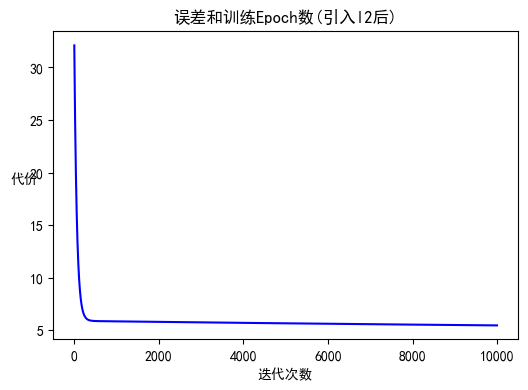

In [21]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(np.arange(iters), loss_his2, 'b')
ax.set_xlabel('迭代次数')
ax.set_ylabel('代价', rotation=0)
ax.set_title('误差和训练Epoch数(引入l2后)')
plt.show()

数据归一化

In [22]:
def normalize_feature(data):
    return (data-data.mean())/data.std()

In [23]:
data=normalize_feature(data)
data.head()

,人口,收益
0,-0.529654,2.132905
1,-0.680150,0.597261
2,0.092716,1.419690
3,-0.298872,1.091575
4,-0.594333,0.178606


In [24]:
cols = data.shape[1]
X_data = data.iloc[:,:cols-1]#X是所有行，去掉最后一列， 未标准化
y_data = data.iloc[:,cols-1:]#X是所有行，最后一列
X_data.insert(0, 'Ones', 1)
X=X_data.values
Y=y_data.values
W=np.array([[0.0],[0.0]]) ## 初始化W系数矩阵，w 是一个(2,1)矩阵

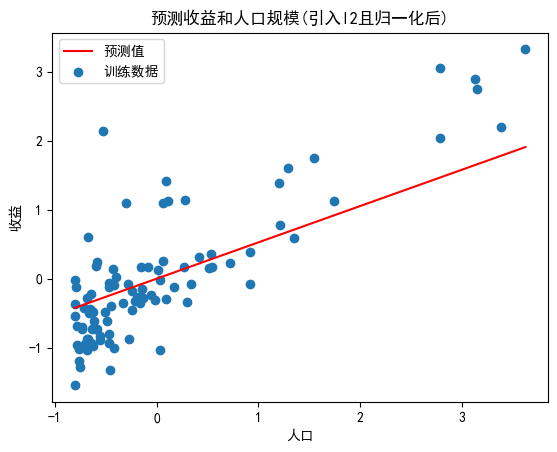

In [25]:
loss_his2,W2=linear_Ridge(X,Y,alpha,iters,lambda_val)

#绘制归一化后的拟合图
x = np.linspace(X_data['人口'].min(), X_data['人口'].max(), 100)
f = W2[0, 0] + (W2[1, 0] * x)

fig, ax = plt.subplots()
ax.plot(x, f, 'r', label='预测值')
ax.scatter(X_data['人口'], data['收益'], label='训练数据')
ax.legend(loc=2)
ax.set(xlabel='人口',
       ylabel='收益',
       title='预测收益和人口规模(引入l2且归一化后)')
plt.show()

绘制归一化后的测试损失曲线

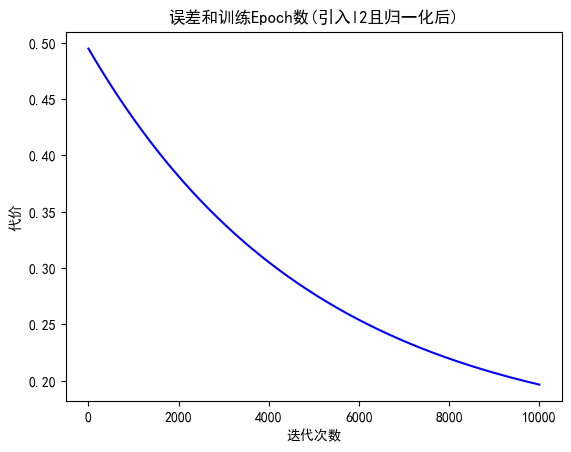

In [26]:
fig, ax = plt.subplots()
ax.plot(np.arange(iters), loss_his2, 'b')
ax.set_xlabel('迭代次数')
ax.set_ylabel('代价', rotation=90)
ax.set_title('误差和训练Epoch数(引入l2且归一化后)')
plt.show()

## 单变量线性回归

用类来实现

## 参考
[1] Andrew Ng. Machine Learning[EB/OL]. StanfordUniversity,2014.https://www.coursera.org/course/ml

[2] 李航. 统计学习方法[M]. 北京: 清华大学出版社,2019.